# WB-XIC, Lab6: Wstęp do wyjaśnień konwolucyjnych sieci neuronowych

- `captum`, `shap`
- [IML](https://christophm.github.io/interpretable-ml-book/neural-networks.html)

Install packages

In [1]:
!pip install scikit-image -U
!pip install shap captum torchinfo

Load packages

In [2]:
import torch
import torchvision
import torchinfo
import shap
import captum
import numpy as np

Load a ResNet-18 model trained on ImageNet

In [3]:
model = torchvision.models.resnet34(pretrained=True)
model = model.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Load [a sample of](https://shap.readthedocs.io/en/stable/generated/shap.datasets.imagenet50.html) ImageNet data

In [4]:
__X, _y = shap.datasets.imagenet50()
_X, y = torch.as_tensor(__X) / 255, torch.as_tensor(_y)

Input images are normalized (by channel)

In [5]:
preprocess = torchvision.transforms.Compose([
   torchvision.transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

Make a prediction

In [6]:
# model(preprocess(_X))

In [7]:
_X.shape

torch.Size([50, 224, 224, 3])

In [8]:
torch.movedim(_X, 3, 1).shape

torch.Size([50, 3, 224, 224])

In [9]:
X = torch.movedim(_X, 3, 1)

In [10]:
torchinfo.summary(model, input_size=X.shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [50, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [50, 64, 112, 112]        128
├─ReLU: 1-3                              [50, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [50, 64, 56, 56]          --
├─Sequential: 1-5                        [50, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [50, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [50, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [50, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [50, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [50, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [50, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [50, 64, 56, 56]          --
│

In [11]:
# model(preprocess(X))
# torch.nn.functional.softmax(model(preprocess(X)), dim=1)
# torch.nn.functional.softmax(model(preprocess(X)), dim=1).sum(axis=1)
torch.nn.functional.softmax(model(preprocess(X)), dim=1).argmax(axis=1)

tensor([829, 132, 814, 746,  42, 476, 738, 643, 598, 976, 839, 133, 918, 109,
        346, 984, 762, 341, 929, 895, 925, 933, 930, 858,  32, 608,  16, 938,
        488, 872, 339, 950, 738, 710, 489,  24, 619, 611, 457, 142, 440, 299,
        893, 452, 430, 997, 620, 885, 709, 895])

Import ImageNet labels

In [12]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2022-04-07 04:46:57--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.137.96
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.137.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2022-04-07 04:46:57 (1.79 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [13]:
import json
with open("imagenet_class_index.json") as json_data:
    idx_to_labels = {idx: label for idx, [_, label] in json.load(json_data).items()}

Visualize images with predictions

In [14]:
import PIL
import matplotlib.pyplot as plt

def show_images(images, k = 3): 
    fig, ax = plt.subplots(k, k, figsize=[6 * k, 6 * k])
    y_hat = torch.nn.functional.softmax(model(preprocess(images)), dim=1)
    preds = y_hat.amax(axis=1)
    preds_idx = y_hat.argmax(axis=1)
    for i, image in enumerate(images):
        pred = preds[i].item()
        pred_idx = preds_idx[i].item()
        ax[i%k, i//k].imshow(image.permute(1, 2, 0))
        ax[i%k, i//k].set_title(f"{pred_idx}: {idx_to_labels[str(pred_idx)]} ({round(pred, 3)})")
        ax[i%k, i//k].axis('off')

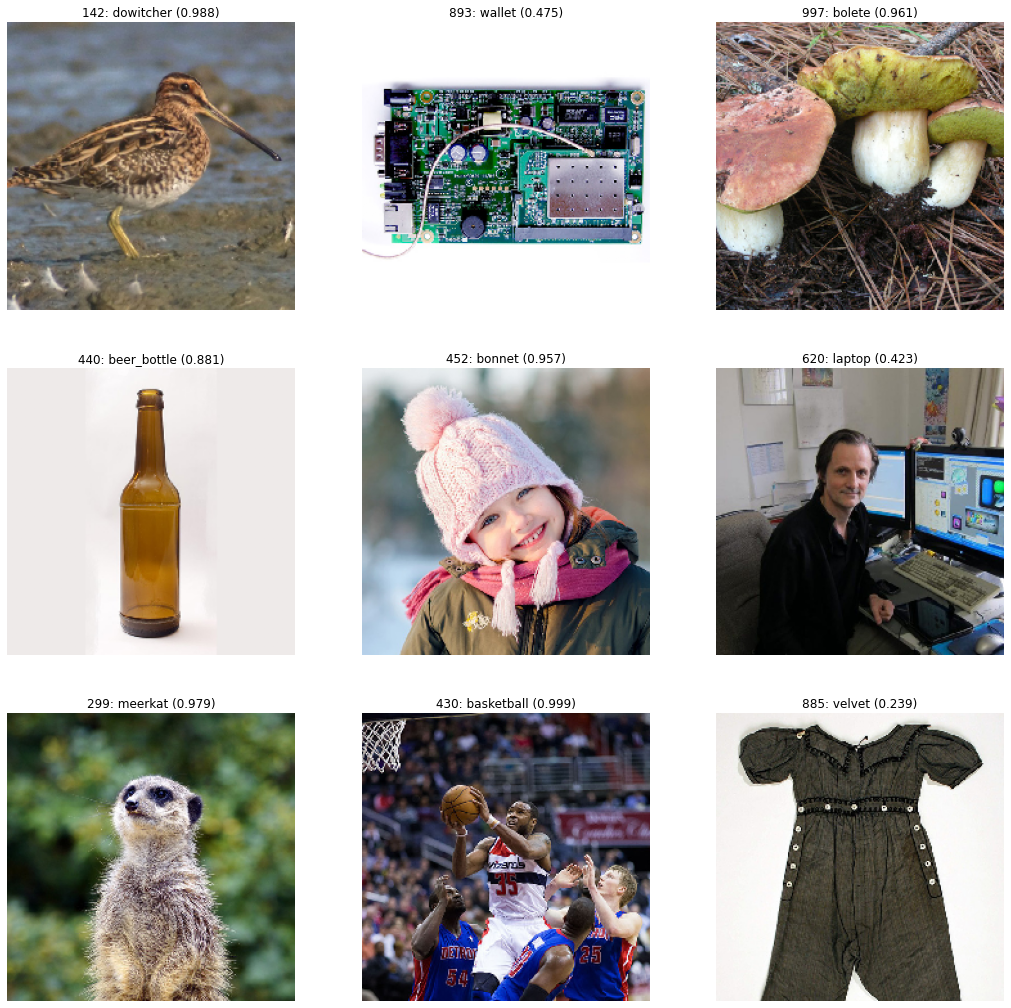

In [15]:
show_images(X[39:48], k=3)

## Local interpretable model-agnostic explanations (LIME)

- Theory: https://christophm.github.io/interpretable-ml-book/lime
- Practice: https://captum.ai/api/lime
- (Segmentation for the mask: https://scikit-image.org/docs/dev/api/skimage.segmentation)

In [20]:
from captum.attr import Lime
explainer = Lime(model)

In [ ]:
from skimage import segmentation
## https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic
mask = segmentation.slic(
    X[39].permute(1, 2, 0).mean(axis=2), 
    n_segments=100, 
    compactness=0.1, 
    start_label=0,
    # channel_axis=2 # error :(
  )
## https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift
mask = segmentation.quickshift(
    X[39].permute(1, 2, 0), 
    kernel_size=14, 
    max_dist=7, 
    ratio=0.5
  )

In [ ]:
print(mask.max())
mask

In [ ]:
attr = explainer.attribute(
    preprocess(X[39].unsqueeze(0)), 
    target=299, 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask),
    show_progress=True
  )

In [ ]:
attr

In [ ]:
def show_image_mask_explanation(image, mask, explanation):
    fig, ax = plt.subplots(1, 3, figsize=[6 * 2, 6])
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title("image")
    ax[1].imshow(mask, cmap="flag")
    ax[1].set_title("segmentation mask")
    ax[2].imshow(explanation, vmin=-1, vmax=1, cmap="RdBu")
    ax[2].set_title("explanation")
    plt.show()

In [ ]:
show_image_mask_explanation(X[39], mask, attr[0].mean(axis=0))

In [ ]:
from captum.attr import visualization

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

In [ ]:
show_attr(attr[0])

## Integrated Gradients (IG)

* Theory: https://www.tensorflow.org/tutorials/interpretability/integrated_gradients
* Practice: https://captum.ai/api/integrated_gradients

In [ ]:
from captum.attr import IntegratedGradients
exp_ig = IntegratedGradients(model)

In [ ]:
attr_ig = exp_ig.attribute(preprocess(X[39].unsqueeze(0)), target=299)

In [ ]:
show_attr(attr_ig[0])

## SHapley Additive exPlanations (SHAP)
- KernelSHAP theory: https://christophm.github.io/interpretable-ml-book/shap
- KernelSHAP practice: https://captum.ai/api/kernel_shap
- SHAP based on DeepLIFT: https://captum.ai/api/deep_lift_shap
- SHAP based on IG: https://captum.ai/api/gradient_shap
- https://github.com/slundberg/shap

In [22]:
from captum.attr import visualization

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

from skimage import segmentation
## https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.quickshift
mask = segmentation.quickshift(
    X[39].permute(1, 2, 0), 
    kernel_size=14, 
    max_dist=7, 
    ratio=0.5
  )

Kernel Shap attribution: 100%|██████████| 200/200 [00:34<00:00,  5.76it/s]


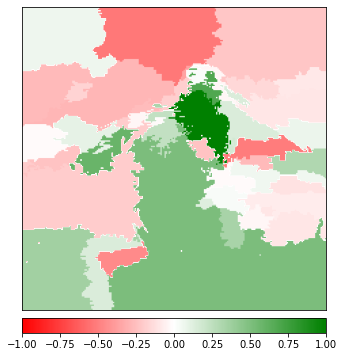

In [23]:
from captum.attr import KernelShap
exp_ks = KernelShap(model)

exp_ks = exp_ks.attribute(
    preprocess(X[39].unsqueeze(0)), 
    target=299, 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask),
    show_progress=True
  )

show_attr(exp_ks[0])

In [24]:
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html
exp_deep = shap.DeepExplainer(model, data=preprocess(X))

sv_deep, idx_deep = exp_deep.shap_values(preprocess(X[39:40]), ranked_outputs=2)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


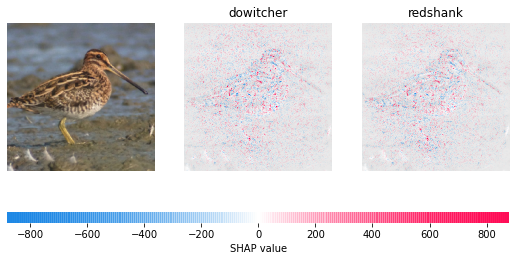

In [25]:
shap.image_plot(
    [sv.squeeze(0).transpose((1, 2, 0)) for sv in sv_deep], 
    X[39].permute(1, 2, 0).numpy(), 
    np.vectorize(lambda x: idx_to_labels[str(x)])(idx_deep)
  )

In [26]:
class NetWrapper(torch.nn.Module):
    def __init__(self, model, preprocess):
        super(NetWrapper, self).__init__()
        self.preprocess = preprocess
        self.model = model

    def forward(self, x):
        x = self.preprocess(x)
        x = self.model(x)
        x = torch.nn.functional.softmax(x, dim=1)
        return x

model_wrapper = NetWrapper(model, preprocess)

# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.GradientExplainer.html
exp_gradient = shap.GradientExplainer(model_wrapper, data=X)

sv_gradient, idx_gradient = exp_gradient.shap_values(X[39:40], ranked_outputs=2)

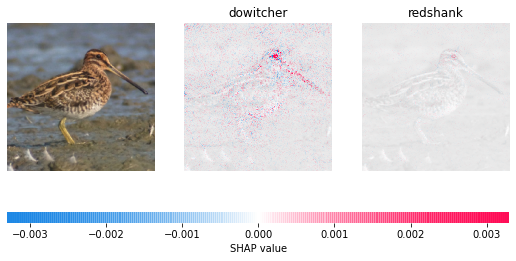

In [27]:
shap.image_plot(
    [sv.squeeze(0).transpose((1, 2, 0)) for sv in sv_gradient], 
    X[39].permute(1, 2, 0).numpy(), 
    np.vectorize(lambda x: idx_to_labels[str(x)])(idx_gradient)
  )

## Captum Insights

https://captum.ai/tutorials/CIFAR_TorchVision_Captum_Insights

https://github.com/aaron-xichen/pytorch-playground

In [28]:
!pip install flask_compress

     |████████████████████████████████| 357 kB 5.3 MB/s 


In [29]:
# get class labels..
dataset = torchvision.datasets.CIFAR100(
    root="data/test", train=False, download=True, transform=torchvision.transforms.ToTensor()
) 
import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict
metadata = unpickle('data/test/cifar-100-python/meta')

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/test/cifar-100-python.tar.gz to data/test


In [30]:
len(metadata['fine_label_names'])

100

In [32]:
!wget http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar100-3a55a987.pth
!wget https://raw.githubusercontent.com/MI2-Education/2022L-WB-XIC/master/labs/lab6/code_cifar100.py

--2022-04-07 05:08:37--  http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar100-3a55a987.pth
Resolving ml.cs.tsinghua.edu.cn (ml.cs.tsinghua.edu.cn)... 101.6.6.219
Connecting to ml.cs.tsinghua.edu.cn (ml.cs.tsinghua.edu.cn)|101.6.6.219|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar100-3a55a987.pth [following]
--2022-04-07 05:08:38--  https://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar100-3a55a987.pth
Connecting to ml.cs.tsinghua.edu.cn (ml.cs.tsinghua.edu.cn)|101.6.6.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37620267 (36M) [application/octet-stream]
Saving to: ‘cifar100-3a55a987.pth.1’

cifar100-3a55a987.p 100%[===================>]  35.88M  10.9MB/s    in 4.5s    

2022-04-07 05:08:43 (8.00 MB/s) - ‘cifar100-3a55a987.pth.1’ saved [37620267/37620267]

--2022-04-07 05:08:43--  https://raw.githubusercontent.com/MI2-Education/2022L-WB-XIC/master/labs/l

Import a model pretrained on CIFAR100 

In [33]:
import code_cifar100

In [34]:
model_cifar100 = code_cifar100.cifar100(n_channel=128, pretrained="cifar100-3a55a987.pth")

Sequential(
  (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(512, eps=1e-05

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar100-3a55a987.pth" to /root/.cache/torch/hub/checkpoints/cifar100-3a55a987.pth


  0%|          | 0.00/35.9M [00:00<?, ?B/s]

In [35]:
import os

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

def baseline_func(input):
    return input * 0

def formatted_data_iter():
    dataset = torchvision.datasets.CIFAR100(
        root="data/test", train=False, download=True, transform=transforms.ToTensor()
    )
    dataloader = iter(
        torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)
    )
    while True:
        images, labels = next(dataloader)
        yield Batch(inputs=images, labels=labels)


normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

visualizer = AttributionVisualizer(
    models=[model_cifar100],
    score_func=lambda o: torch.nn.functional.softmax(o, dim=1),
    classes=metadata['fine_label_names'],
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[normalize],
        )
    ],
    dataset=formatted_data_iter(),
)

In [36]:
# visualizer.render(debug=True) # doesn't work?

In [37]:
visualizer.serve()

Output()

`python -m captum.insights.example`

## Neuron & layer attribution

### Task 1
Use a chosen **neuron** atrribution method, e.g. IG (https://captum.ai/api/neuron.html#neuron-integrated-gradients) on:
- Beginner: ImageNet (like the above)
- Intermediate: CIFAR-100 (based on the above)


### Task 2
Use a chosen **layer** atrribution method, e.g. IG (https://captum.ai/api/layer.html#layer-integrated-gradients) on:
- Beginner: ImageNet (like the above)
- Intermediate: CIFAR-100 (based on the above)
